# Andrii Shevtsov homework 3, IASA NLP

## Imports and constants

In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
import gensim
import matplotlib.pyplot as plt

In [6]:
DISASTERS_TRAIN_PATH = '../../data/nlp_getting_started/train.csv'
DISASTERS_TEST_PATH = '../../data/nlp_getting_started/test.csv'

## Natural Language Processing with Disaster Tweets

### Validation consistency

In the original problem, there is a simple random train/test split, so we will also make some random ungrouped splits and see the tresults.

In [13]:
df_twitter_train = pd.read_csv(DISASTERS_TRAIN_PATH, index_col='id')
df_twitter_test = pd.read_csv(DISASTERS_TEST_PATH, index_col='id')

df_twitter_train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [26]:
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'good', 'bad', 'people']) #stopwords extended a bit

def preprocess(text, join_back=True, stemmer = PorterStemmer()):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and 
            token not in stop_words
        ):
            result.append(token)
    
    result = [stemmer.stem(word) for word in result]
    if join_back:
        result = " ".join(result)
    
    return result

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
create_full_text = lambda row: row['text'] + ' ' + (str(row['keyword']) if not pd.isnull(row['keyword']) else '') + ' ' + (str(row['location']) if not pd.isnull(row['location']) else '')

df_twitter_train['text_full'] = df_twitter_train.apply(create_full_text, axis=1)
df_twitter_test['text_full'] = df_twitter_test.apply(create_full_text, axis=1)

df_twitter_train['text_clean'] = df_twitter_train['text_full'].apply(preprocess)
df_twitter_test['text_clean'] = df_twitter_test['text_full'].apply(preprocess)

df_twitter_train.head()

,keyword,location,text,target,text_clean,text_full
id,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak allah forgiv,Our Deeds are the Reason of this #earthquake M...
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest near la rong sask canada,Forest fire near La Ronge Sask. Canada
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,All residents asked to 'shelter in place' are ...
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,receiv wildfir evacu order california,"13,000 people receive #wildfires evacuation or..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,Just got sent this photo from Ruby #Alaska as ...


In [80]:
classifiers = {
    "logistic_regression": Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=5,
        max_features=30000
    )),  
    ('classifier', LogisticRegression())
]),
    "support_vector_machine": Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=5,
        max_features=30000
    )),  
    ('classifier', LinearSVC(dual="auto"))
]),
    "decision_tree": Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=5,
        max_features=30000
    )),  
    ('classifier', DecisionTreeClassifier())
])
              }

Let's compare three methods: holdout set, k-fold and stratified K-fold.

#### Holdout set

In [81]:
X_train, y_train = df_twitter_train['text_clean'], df_twitter_train['target']
X_test = df_twitter_test['text_clean']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [87]:
for pipe_name, pipe in classifiers.items():
    pipe.fit(X_train, y_train)
    train_score = f1_score(y_train, pipe.predict(X_train))
    val_score = f1_score(y_val, pipe.predict(X_val))
    
    y_test_pred = pipe.predict(X_test)
    df_submission = df_twitter_test.copy()
    df_submission['target'] = y_test_pred
    df_submission.loc[:, ['target']].to_csv(f'./submissions/submission_{pipe_name}_holdout.csv')
    
    print(f"Holdout set, classifier {pipe_name}:\n\tTrain F1 = {train_score:.4f}\n\tVal F1  = {val_score:.4f}")

Holdout set, classifier logistic_regression:
	Train F1 = 0.8152
	Val F1  = 0.7481
Holdout set, classifier support_vector_machine:
	Train F1 = 0.8875
	Val F1  = 0.7377
Holdout set, classifier decision_tree:
	Train F1 = 0.9896
	Val F1  = 0.6796


#### 5-fold CV

In [104]:
cv = KFold(n_splits=5, shuffle=True)

In [105]:
for pipe_name, pipe in classifiers.items():
    val_scores = cross_val_score(pipe, df_twitter_train['text_clean'], df_twitter_train['target'], cv=cv, scoring='f1')
    
    pipe.fit(df_twitter_train['text_clean'], df_twitter_train['target'])
    
    y_test_pred = pipe.predict(X_test)
    df_submission = df_twitter_test.copy()
    df_submission['target'] = y_test_pred
    df_submission.loc[:, ['target']].to_csv(f'./submissions/submission_{pipe_name}_kfold.csv')

    print(f"K Fold, classifier {pipe_name}:\n\tMean val F1  = {(val_scores).mean():.4f}")

K Fold, classifier logistic_regression:
	Mean val F1  = 0.7478
K Fold, classifier support_vector_machine:
	Mean val F1  = 0.7328
K Fold, classifier decision_tree:
	Mean val F1  = 0.6542


#### Stratified 5-fold CV

We don't save submissions here, because they are the same as for the simple KFold

In [106]:
cv_strat = StratifiedKFold(n_splits=5, shuffle=True)

In [107]:
for pipe_name, pipe in classifiers.items():
    val_scores = cross_val_score(pipe, df_twitter_train['text_clean'], df_twitter_train['target'], cv=cv_strat, scoring='f1')
    print(f"Stratified K Fold, classifier {pipe_name}:\n\tMean val F1  = {(val_scores).mean():.4f}")

Stratified K Fold, classifier logistic_regression:
	Mean val F1  = 0.7411
Stratified K Fold, classifier support_vector_machine:
	Mean val F1  = 0.7407
Stratified K Fold, classifier decision_tree:
	Mean val F1  = 0.6578


#### Results

Scores look like the following:

![Scores for these submissions](./images/submissions_disaster_tweets.png)

Let's draw a plot of evaluation / leaderboard score: 

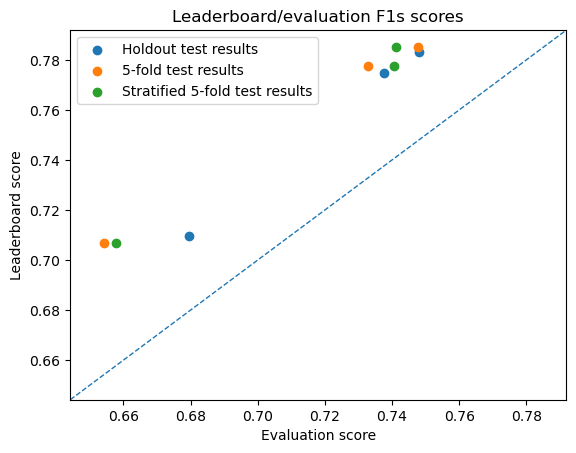

In [110]:
plt.scatter([0.7481, 0.7377, 0.6796], [0.78302, 0.77474, 0.70977], label="Holdout test results")
plt.scatter([0.7478, 0.7328, 0.6542], [0.78516, 0.7775, 0.70671], label="5-fold test results")
plt.scatter([0.7411, 0.7407, 0.6578], [0.78516, 0.7775, 0.70671], label="Stratified 5-fold test results")


plt.xlabel("Evaluation score")
plt.ylabel("Leaderboard score")
plt.title("Leaderboard/evaluation F1s scores")
plt.legend()

plt.axline((0.6509, 0.6509), (0.78516, 0.78516), linestyle="--", linewidth=1)

plt.show()

Evaluation score definitely correlates with its leaderboard mate, but it is definitely a little bit lower for all the pipelines and evaluations.

Probably it is the case because actually competition uses the macro F1, not simply F1 for the positive label.

Let's try it:

In [98]:
for pipe_name, pipe in classifiers.items():
    pipe.fit(X_train, y_train)
    train_score = f1_score(y_train, pipe.predict(X_train), average='macro')
    val_score = f1_score(y_val, pipe.predict(X_val), average='macro')
    
    print(f"Holdout set, classifier {pipe_name}:\n\tTrain F1 = {train_score:.4f}\n\tVal F1  = {val_score:.4f}")

Holdout set, classifier logistic_regression:
	Train F1 = 0.8456
	Val F1  = 0.7910
Holdout set, classifier support_vector_machine:
	Train F1 = 0.9039
	Val F1  = 0.7789
Holdout set, classifier decision_tree:
	Train F1 = 0.9909
	Val F1  = 0.7162


In [111]:
for pipe_name, pipe in classifiers.items():
    val_scores = cross_val_score(pipe, df_twitter_train['text_clean'], df_twitter_train['target'], cv=cv, 
                                 scoring=make_scorer(f1_score, average='macro'))
    print(f"K Fold, classifier {pipe_name}:\n\tMean val macro F1  = {(val_scores).mean():.4f}")

K Fold, classifier logistic_regression:
	Mean val macro F1  = 0.7814
K Fold, classifier support_vector_machine:
	Mean val macro F1  = 0.7787
K Fold, classifier decision_tree:
	Mean val macro F1  = 0.7057


In [112]:
for pipe_name, pipe in classifiers.items():
    val_scores = cross_val_score(pipe, df_twitter_train['text_clean'], df_twitter_train['target'], cv=cv_strat, 
                                 scoring=make_scorer(f1_score, average='macro'))
    print(f"Stratified K Fold, classifier {pipe_name}:\n\tMean val F1  = {(val_scores).mean():.4f}")

Stratified K Fold, classifier logistic_regression:
	Mean val F1  = 0.7832
Stratified K Fold, classifier support_vector_machine:
	Mean val F1  = 0.7728
Stratified K Fold, classifier decision_tree:
	Mean val F1  = 0.6999


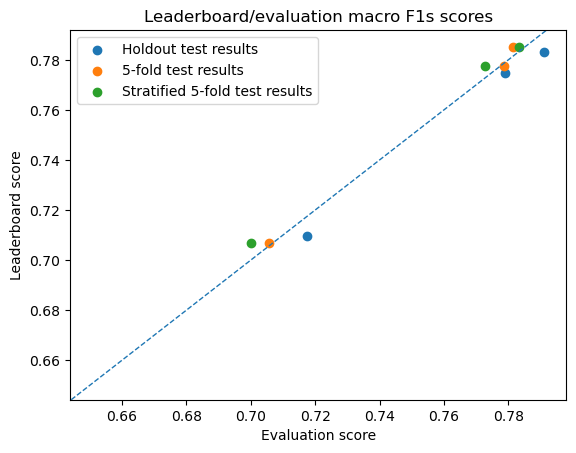

In [113]:
plt.scatter([0.7910, 0.7789, 0.7175], [0.78302, 0.77474, 0.70977], label="Holdout test results")
plt.scatter([0.7814, 0.7787, 0.7057], [0.78516, 0.7775, 0.70671], label="5-fold test results")
plt.scatter([0.7832, 0.7728, 0.6999], [0.78516, 0.7775, 0.70671], label="Stratified 5-fold test results")


plt.xlabel("Evaluation score")
plt.ylabel("Leaderboard score")
plt.title("Leaderboard/evaluation macro F1s scores")
plt.legend()

plt.axline((0.6509, 0.6509), (0.78516, 0.78516), linestyle="--", linewidth=1)

plt.show()

Here, we can clearly see that k fold is the best one predictive for such random initialization. But, actually, all methods are pretty accurate on the task.

### Adversarial validation

In [120]:
df_adversarial = pd.concat([df_twitter_train, df_twitter_test]).reset_index()
df_adversarial.loc[:, 'target'] = len(df_twitter_train)*[0] + len(df_twitter_test)*[1]

X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split(
    df_adversarial['text_clean'], df_adversarial['target'], stratify=df_adversarial['target'], test_size=0.2
)

for pipe_name, pipe in classifiers.items():
    pipe.fit(X_train_adv, y_train_adv)
    
    y_train_pred = pipe_classification.predict(X_train_adv)
    y_val_pred = pipe_classification.predict(X_val_adv)
    
    train_score = f1_score(y_train_adv, y_train_pred, average='macro')
    val_score = f1_score(y_val_adv, y_val_pred, average='macro')
    val_roc_auc = roc_auc_score(y_val_adv, pipe_classification.predict_proba(X_val_adv)[:, 1])
    
    print(f"Classifier {pipe_name}:\n\tTrain macro F1 = {train_score:.4f}\n\tVal macro F1  = {val_score:.4f}")
    print(f"\tVal ROC AUC = {val_roc_auc}")

Classifier logistic_regression:
	Train macro F1 = 0.4653
	Val macro F1  = 0.4251
	Val ROC AUC = 0.5032025531940566
Classifier support_vector_machine:
	Train macro F1 = 0.4653
	Val macro F1  = 0.4251
	Val ROC AUC = 0.5032025531940566
Classifier decision_tree:
	Train macro F1 = 0.4653
	Val macro F1  = 0.4251
	Val ROC AUC = 0.5032025531940566


In [116]:
print("Percent of test:", len(df_twitter_test)/len(df_adversarial))

Percent of test: 0.3000183891136447


Confusion matrix for such a classifier, if it can't find any leaks, should look like:

|                   | Test     | Train     |
| ----------------: | :------: | :-------: |
| Test              | 0.3 * 0.3 = 0.09 | 0.3 * 0.7 = 0.21 |
| Train             | 0.7 * 0.3 = 0.21 | 0.7 * 0.7 = 0.49 |

For the test class, F1 should be 2\*0.09/(2\*0.09 + 0.21 + 0.21) = 0.3

For the train class, F1 should be 2\*0.49/(2\*0.49 + 0.21 + 0.21) = 0.7

So, for completely independent classes macro F1 should be (0.3 + 0.7) / 2 = 0.5

Macro F1 is smaller in our case, so there are clearly no leaks.

ROC AUC score also shows that we have completely randomized predictions.

## CommonLit - Evaluate Student Summaries

### Regular K-fold

### Group K-fold

### Conclusions on the LB-val correlation